## LSTM and CNN to predict genre using MFCC features

Using https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification dataset


In [ ]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display


#from IPython.display import Audio

!pip install datasets
from datasets import load_dataset, Audio, DatasetDict

#!pip install git+https://github.com/huggingface/transformers
!pip install -U accelerate
!pip install -U transformers
!pip install evaluate

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/erdos24')

Mounted at /content/drive


In [3]:
import logging

gtzan = load_dataset("marsyas/gtzan", split='train')

gtzan

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for marsyas/gtzan contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/marsyas/gtzan
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.war

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['file', 'audio', 'genre'],
    num_rows: 999
})

In [4]:
def extract_mfcc(audio_array, sampling_rate, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=1):
    # calculate segment length in samples
    segment_length = int(len(audio_array) / num_segments)

    mfcc_segments = []

    for i in range(num_segments):
        # calculate start and end indices for the current segment
        start = i * segment_length
        end = start + segment_length

        # extract the segment and compute its MFCCs
        audio_segment = audio_array[start:end]
        mfcc = librosa.feature.mfcc(y=audio_segment, sr=sampling_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc_segments.append(mfcc.T)  # transpose to have time dimension first

    return mfcc_segments

    # n_mfcc = specifies number of mel-frequency cepstral coefficients to extract from each audio signal. Ranges typically from 12-40.
    # n_fft = number of points in the fast fourier transform to calculate the spectogram of the audio signal. Larger value results in higher frequency resolution but lower time resolution. Typical values are powers of 2: 512,1024,2048
    # hop_length = number of audio samples between successive frames in spectrogram or MFCC calculation. Larger value results in lower time resolution and less overlap. Typical values are fraction of nftt/2 or nftt/4
    # num_segments = used for dividing audio signal into smaller segments. E.g. 30 second audio clip, 3 second segments -> num_segments =10

In [5]:
mfcc_features = []

for song in gtzan['audio']:
    audio_array = song['array']
    sampling_rate = song['sampling_rate']
    mfcc_segments = extract_mfcc(audio_array, sampling_rate, n_mfcc=40, n_fft=2048, hop_length=512, num_segments=10)
    mfcc_features.append(mfcc_segments)

In [6]:
# convert mfcc_features to a numpy array
X = np.array(mfcc_features)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (999, 10) + inhomogeneous part.

In [7]:
# find maximum length of the MFCC feature arrays
max_length = max(max(len(mfcc) for mfcc in song) for song in mfcc_features)

# Add padding to the MFCC feature arrays with zeros
padded_mfcc_features = []
for song in mfcc_features:
    padded_song = []
    for mfcc in song:
        padding = np.zeros((max_length - len(mfcc), mfcc.shape[1]))
        padded_mfcc = np.vstack([mfcc, padding])
        padded_song.append(padded_mfcc)
    padded_mfcc_features.append(padded_song)

# convert padded list into NumPy array
X = np.array(padded_mfcc_features)

# convert label to numpy array
y = np.array(gtzan['genre'])

# split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set size:", X_train.shape, y_train.shape)
print("Evaluation set size:", X_eval.shape, y_eval.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (699, 10, 132, 40) (699,)
Evaluation set size: (150, 10, 132, 40) (150,)
Test set size: (150, 10, 132, 40) (150,)


In [8]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) # input shape: segments each audio is divided into, # of time steps in each segment, # of MFCC at each time step
input_shape

(10, 132, 40)

### LSTM

In [9]:
import tensorflow as tf
import numpy as np
import random

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Reshape((X_train.shape[1] * X_train.shape[2], X_train.shape[3]), input_shape=input_shape),

    LSTM(132, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(64, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    BatchNormalization(),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(10, activation='softmax')
])

In [11]:
optimization = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimization,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1320, 40)          0         
                                                                 
 lstm (LSTM)                 (None, 1320, 132)         91344     
                                                                 
 dropout (Dropout)           (None, 1320, 132)         0         
                                                                 
 batch_normalization (Batch  (None, 1320, 132)         528       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 64)                50432     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [12]:
# train model
model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_eval, y_eval), callbacks=[early_stopping], verbose=2
)

Epoch 1/100
22/22 - 9s - loss: 2.8609 - accuracy: 0.1545 - val_loss: 2.4933 - val_accuracy: 0.2467 - 9s/epoch - 426ms/step
Epoch 2/100
22/22 - 2s - loss: 2.4388 - accuracy: 0.2504 - val_loss: 2.3770 - val_accuracy: 0.3400 - 2s/epoch - 95ms/step
Epoch 3/100
22/22 - 2s - loss: 2.2156 - accuracy: 0.3448 - val_loss: 2.2631 - val_accuracy: 0.3467 - 2s/epoch - 95ms/step
Epoch 4/100
22/22 - 2s - loss: 2.0983 - accuracy: 0.3662 - val_loss: 2.1718 - val_accuracy: 0.4200 - 2s/epoch - 96ms/step
Epoch 5/100
22/22 - 2s - loss: 1.9532 - accuracy: 0.4220 - val_loss: 2.0276 - val_accuracy: 0.4800 - 2s/epoch - 96ms/step
Epoch 6/100
22/22 - 2s - loss: 1.7734 - accuracy: 0.4950 - val_loss: 1.9247 - val_accuracy: 0.4933 - 2s/epoch - 96ms/step
Epoch 7/100
22/22 - 2s - loss: 1.6413 - accuracy: 0.5351 - val_loss: 1.8781 - val_accuracy: 0.4200 - 2s/epoch - 95ms/step
Epoch 8/100
22/22 - 2s - loss: 1.5391 - accuracy: 0.5908 - val_loss: 1.8040 - val_accuracy: 0.4400 - 2s/epoch - 95ms/step
Epoch 9/100
22/22 - 2s 

In [13]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

np.sum(y_pred == y_test) / len(y_test)

5/5 [==============================] - 1s 49ms/step


0.5133333333333333

In [14]:
# Test set evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# calculate the confusion matrix, accuracy, f1
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

conf_matrix, accuracy, f1

(array([[ 6,  0,  0,  3,  0,  0,  4,  0,  1,  1],
        [ 0, 12,  0,  1,  0,  2,  0,  0,  0,  0],
        [ 2,  0,  5,  1,  0,  1,  3,  1,  2,  0],
        [ 0,  1,  0,  3,  2,  0,  1,  2,  2,  4],
        [ 0,  0,  0,  1,  9,  0,  3,  0,  1,  1],
        [ 1,  0,  0,  1,  0, 11,  0,  0,  1,  1],
        [ 1,  0,  0,  0,  2,  0, 12,  0,  0,  0],
        [ 0,  0,  0,  1,  1,  0,  0, 12,  1,  0],
        [ 1,  0,  0,  2,  3,  0,  0,  1,  5,  3],
        [ 1,  0,  0,  1,  0,  2,  5,  1,  3,  2]]),
 0.5133333333333333,
 0.5059529600859438)

### Bidirectional LSTM


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Reshape, Bidirectional

tf.keras.backend.clear_session()

model = Sequential()
model.add(Reshape((X_train.shape[1] * X_train.shape[2], X_train.shape[3]), input_shape=input_shape))

#BiLSTM
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.3))
model.add(BatchNormalization())

#BiLSTM
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# dense layer w.L2 and dropout
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

# softmax for multi-class classification
model.add(Dense(10, activation='softmax'))

# compile model
optimization = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimization,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

# train model
model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_eval, y_eval), callbacks=[early_stopping], verbose=2
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1320, 40)          0         
                                                                 
 bidirectional (Bidirection  (None, 1320, 256)         173056    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1320, 256)         0         
                                                                 
 batch_normalization (Batch  (None, 1320, 256)         1024      
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                        

In [16]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Test set evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# calculate the confusion matrix, accuracy, f1
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

conf_matrix, accuracy, f1

5/5 [==============================] - 2s 92ms/step


(array([[ 7,  0,  1,  2,  0,  2,  1,  0,  1,  1],
        [ 0, 13,  0,  0,  0,  2,  0,  0,  0,  0],
        [ 1,  0,  4,  4,  0,  1,  0,  1,  1,  3],
        [ 0,  1,  0,  4,  2,  0,  1,  3,  2,  2],
        [ 0,  0,  1,  0,  4,  0,  2,  2,  4,  2],
        [ 0,  0,  3,  1,  0, 11,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 12,  0,  0,  3],
        [ 0,  0,  1,  1,  1,  0,  0, 11,  1,  0],
        [ 4,  1,  0,  1,  1,  0,  0,  0,  6,  2],
        [ 2,  0,  1,  1,  1,  3,  1,  1,  0,  5]]),
 0.5133333333333333,
 0.5033068790573861)

### CNN


In [17]:
# convert mfcc_features to a numpy array

# find maximum length of the MFCC feature arrays
max_length = max(max(len(mfcc) for mfcc in song) for song in mfcc_features)

# add padding to the MFCC feature arrays with zeros
padded_mfcc_features = []
for song in mfcc_features:
    padded_song = []
    for mfcc in song:
        padding = np.zeros((max_length - len(mfcc), mfcc.shape[1]))
        padded_mfcc = np.vstack([mfcc, padding])
        padded_song.append(padded_mfcc)
    padded_mfcc_features.append(padded_song)

# convert padded list into NumPy array
X = np.array(padded_mfcc_features)

# convert label to numpy array
y = np.array(gtzan['genre'])

# split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
X_eval, X_test, y_eval, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set size:", X_train.shape, y_train.shape)
print("Evaluation set size:", X_eval.shape, y_eval.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (699, 10, 132, 40) (699,)
Evaluation set size: (150, 10, 132, 40) (150,)
Test set size: (150, 10, 132, 40) (150,)


In [18]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
input_shape

(10, 132, 40)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import models, layers

tf.keras.backend.clear_session()

cnn_model = models.Sequential([
    # conv layer with 'same' padding to preserve dimensions
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.3),

    # conv layer, again with 'same' padding
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Dropout(0.3),

    # global Average Pooling layer to reduce dimensions without going to zero
    layers.GlobalAveragePooling2D(),

    # dense layers for classification
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # higher dropout for regularization
    layers.Dense(10, activation='softmax')  # 10 classes
])

cnn_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

cnn_model.summary()

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# train model
cnn_model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_data=(X_eval, y_eval),
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 132, 32)       11552     
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 66, 32)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 5, 66, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 66, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 33, 64)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 3, 33, 64)         0

In [20]:
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

5/5 - 0s - loss: 1.2870 - accuracy: 0.6800 - 41ms/epoch - 8ms/step

Test accuracy: 0.6800000071525574


5/5 - 0s - loss: 1.2870 - accuracy: 0.6800 - 40ms/epoch - 8ms/step
5/5 [==============================] - 0s 4ms/step


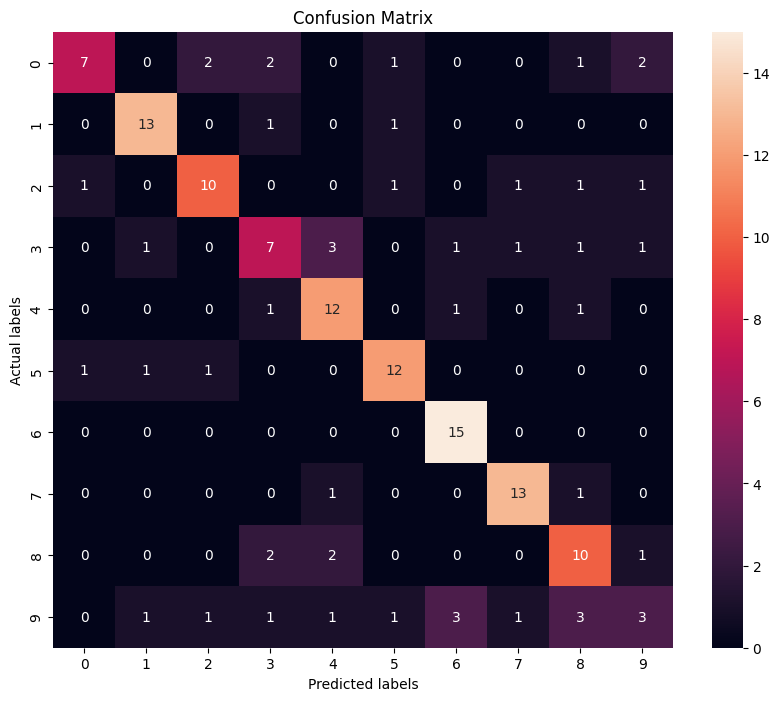

              precision    recall  f1-score   support

       blues       0.78      0.47      0.58        15
   classical       0.81      0.87      0.84        15
     country       0.71      0.67      0.69        15
       disco       0.50      0.47      0.48        15
      hiphop       0.63      0.80      0.71        15
        jazz       0.75      0.80      0.77        15
       metal       0.75      1.00      0.86        15
         pop       0.81      0.87      0.84        15
      reggae       0.56      0.67      0.61        15
        rock       0.38      0.20      0.26        15

    accuracy                           0.68       150
   macro avg       0.67      0.68      0.66       150
weighted avg       0.67      0.68      0.66       150

[[ 7  0  2  2  0  1  0  0  1  2]
 [ 0 13  0  1  0  1  0  0  0  0]
 [ 1  0 10  0  0  1  0  1  1  1]
 [ 0  1  0  7  3  0  1  1  1  1]
 [ 0  0  0  1 12  0  1  0  1  0]
 [ 1  1  1  0  0 12  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0]
 [ 0  0  0

In [21]:
# evaluate the model on the test set
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=2)

# generate predictions
predictions = cnn_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# create the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)


# Test set evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# calculate the confusion matrix, accuracy, f1
conf_matrix = confusion_matrix(y_test, predicted_labels)
accuracy = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels, average='weighted')

# create classification report
GENRES = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
report = classification_report(y_test, predicted_labels, target_names=GENRES)

# plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

print(report)

print(conf_matrix, accuracy, f1)